### Prepare Topographical (lat/lon/alt) Information as Numpy arrays:

This code is preparing topographical information for two different grids: TSMP and HRES.


For TSMP grid:

    Load topographical information from a netCDF file.
    Extract LANDMASK, XLAT_M, XLONG_M, and HGT_M variables.
    Slice and reshape LANDMASK variable to (412, 424).
    Slice XLAT_M, XLONG_M, and HGT_M variables to (412, 424).
    Threshold HGT_M variable so that any negative values are set to zero.
    Combine lats, lons, and topo variables into a single numpy array SP with shape (412, 424, 3).
    Save SP array to disk as an .npz file.
    
    
For HRES grid:

    Load topographical information from a netCDF file (USGS GMTED2010)
    Extract latitude, longitude, and elevation variables.
    Create a meshgrid for the latitude and longitude arrays, with the dimensions of the resulting arrays being (125, 196).
    Threshold elevation variable so that any negative values are set to zero.
    Combine lats, longs, and topo_elev variables into a single numpy array SP with shape (125, 196, 3).
    Save SP array to disk as an .npz file.

In [1]:
# for preparing the topographical information for TSMP grid

from py_env_hpc import *
topo_dir='/p/project/deepacf/kiste/patakchiyousefi1/IO/03-TOPOGRAPHY/geo_em.d02_MODISLakes.nc'
ncfile = nc4.Dataset(topo_dir, 'r')
lm11 = ncfile.variables['LANDMASK'][:]
lm11 = lm11[0,12:424,12:436].reshape(412,424) #lm11.reshape(412,424)#lm11[0,12:424,12:436].reshape(412,424)
lats = ncfile.variables['XLAT_M'][0,(12):(424),(12):(436)]
lons = ncfile.variables['XLONG_M'][0,(12):(424),(12):(436)]
topo = ncfile.variables['HGT_M'][0,(12):(424),(12):(436)]
topo[topo<0] = 0
SP = np.stack([lats, lons, topo], axis=2)
np.savez("/p/project/deepacf/kiste/patakchiyousefi1/IO/03-TOPOGRAPHY/EU-11-TOPO.npz", SP)

In [26]:
# for preparing the topographical information for HRES grid

from py_env_hpc import *
topo_dir='/p/scratch/deepacf/kiste/patakchiyousefi1/HRES_TOPO/GMTED2010_15n030_0125deg.nc.remapbil.nc'
topo=xarray.open_dataset(topo_dir)
lat = topo["latitude"]
lon = topo["longitude"]
lats, longs = np.meshgrid(lat, lon, indexing='ij')
topo['elevation'] = topo['elevation'].where(topo['elevation'] > 0, 0)
topo_elev=topo["elevation"].values
SP = np.stack([lats, longs, topo_elev], axis=2)
np.savez("/p/project/deepacf/kiste/patakchiyousefi1/IO/03-TOPOGRAPHY/HSAF-TOPO.npz", SP)

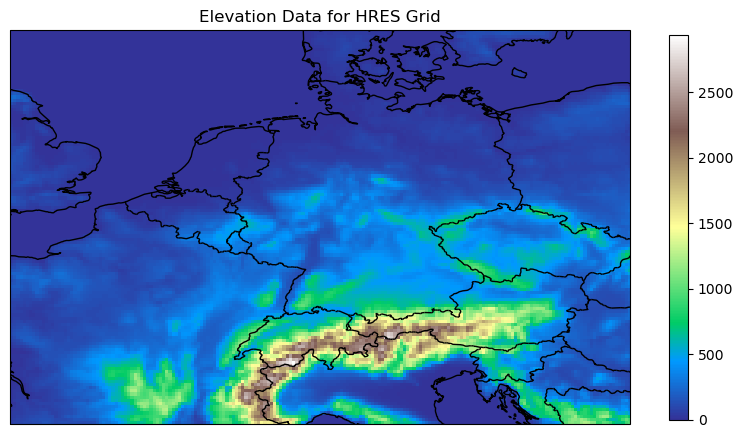

In [32]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# create a plot with Plate Carree projection
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# plot the elevation data
elev = ax.imshow(topo.elevation, origin='upper', extent=[topo.longitude.min(),
                topo.longitude.max(), topo.latitude.min(), topo.latitude.max()],
                transform=ccrs.PlateCarree(), cmap='terrain')

# add coastlines and country borders
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

# add a colorbar and title
cbar = plt.colorbar(elev, ax=ax, shrink=0.5)
ax.set_title('Elevation Data for HRES Grid')

plt.show()